<a href="https://colab.research.google.com/github/akalausichcodes/GroceryShelfVision/blob/main/GroceryShelfVision2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import cv2
import numpy as np
from PIL import Image
import pytesseract
from google.colab import files
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
import re  # Add this import for regular expressions

In [38]:

# Assume a standard meat package width of 6 inches for scale
STANDARD_PACKAGE_WIDTH_INCHES = 6

def upload_image():
    uploaded = files.upload()
    filename = next(iter(uploaded))
    return cv2.imread(filename)

def detect_meat_packages(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use multiple thresholds to catch more items
    edges1 = cv2.Canny(blur, 30, 150)
    edges2 = cv2.Canny(blur, 10, 50)
    edges = cv2.bitwise_or(edges1, edges2)

    kernel = np.ones((3,3), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)

    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    packages = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        if 30 < w < 400 and 30 < h < 300 and 0.2 < aspect_ratio < 5:
            packages.append((x, y, w, h))

    return packages

def calculate_pixel_to_inch_ratio(packages):
    # Use the median width of detected packages as reference
    widths = [w for _, _, w, _ in packages]
    median_width_pixels = np.median(widths)
    return STANDARD_PACKAGE_WIDTH_INCHES / median_width_pixels

def extract_text(image, package):
    x, y, w, h = package
    roi = image[y:y+h, x:x+w]

    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    custom_config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(thresh, config=custom_config).strip()

    return text

def analyze_color(image, package):
    x, y, w, h = package
    roi = image[y:y+h, x:x+w]

    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = roi.reshape((roi.shape[0] * roi.shape[1], 3))

    kmeans = KMeans(n_clusters=3)
    kmeans.fit(roi)

    colors = kmeans.cluster_centers_
    labels = kmeans.labels_

    percentages = [np.sum(labels == i) / len(labels) for i in range(3)]

    return [(color.astype(int), percentage) for color, percentage in zip(colors, percentages)]

def estimate_price(text):
    price_matches = re.findall(r'\$?\d+\.\d{2}', text)
    if price_matches:
        return max(float(price.replace('$', '')) for price in price_matches)
    return None

def analyze_meat_shelf():
    image = upload_image()
    packages = detect_meat_packages(image)
    pixel_to_inch_ratio = calculate_pixel_to_inch_ratio(packages)

    results = []
    for i, package in enumerate(packages):
        text = extract_text(image, package)
        colors = analyze_color(image, package)
        price = estimate_price(text)

        x, y, w, h = package
        width_inches = w * pixel_to_inch_ratio
        height_inches = h * pixel_to_inch_ratio

        results.append({
            'package_id': i+1,
            'position': f"({x}, {y})",
            'dimensions_pixels': f"{w} x {h} pixels",
            'dimensions_inches': f"{width_inches:.2f} x {height_inches:.2f} inches",
            'text': text,
            'dominant_colors': colors,
            'estimated_price': f"${price:.2f}" if price else "N/A"
        })

    # Display the image with detected packages
    for i, (x, y, w, h) in enumerate(packages):
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image, f"{i+1}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    cv2_imshow(image)

    return results

Saving Case Result 1.png to Case Result 1 (8).png


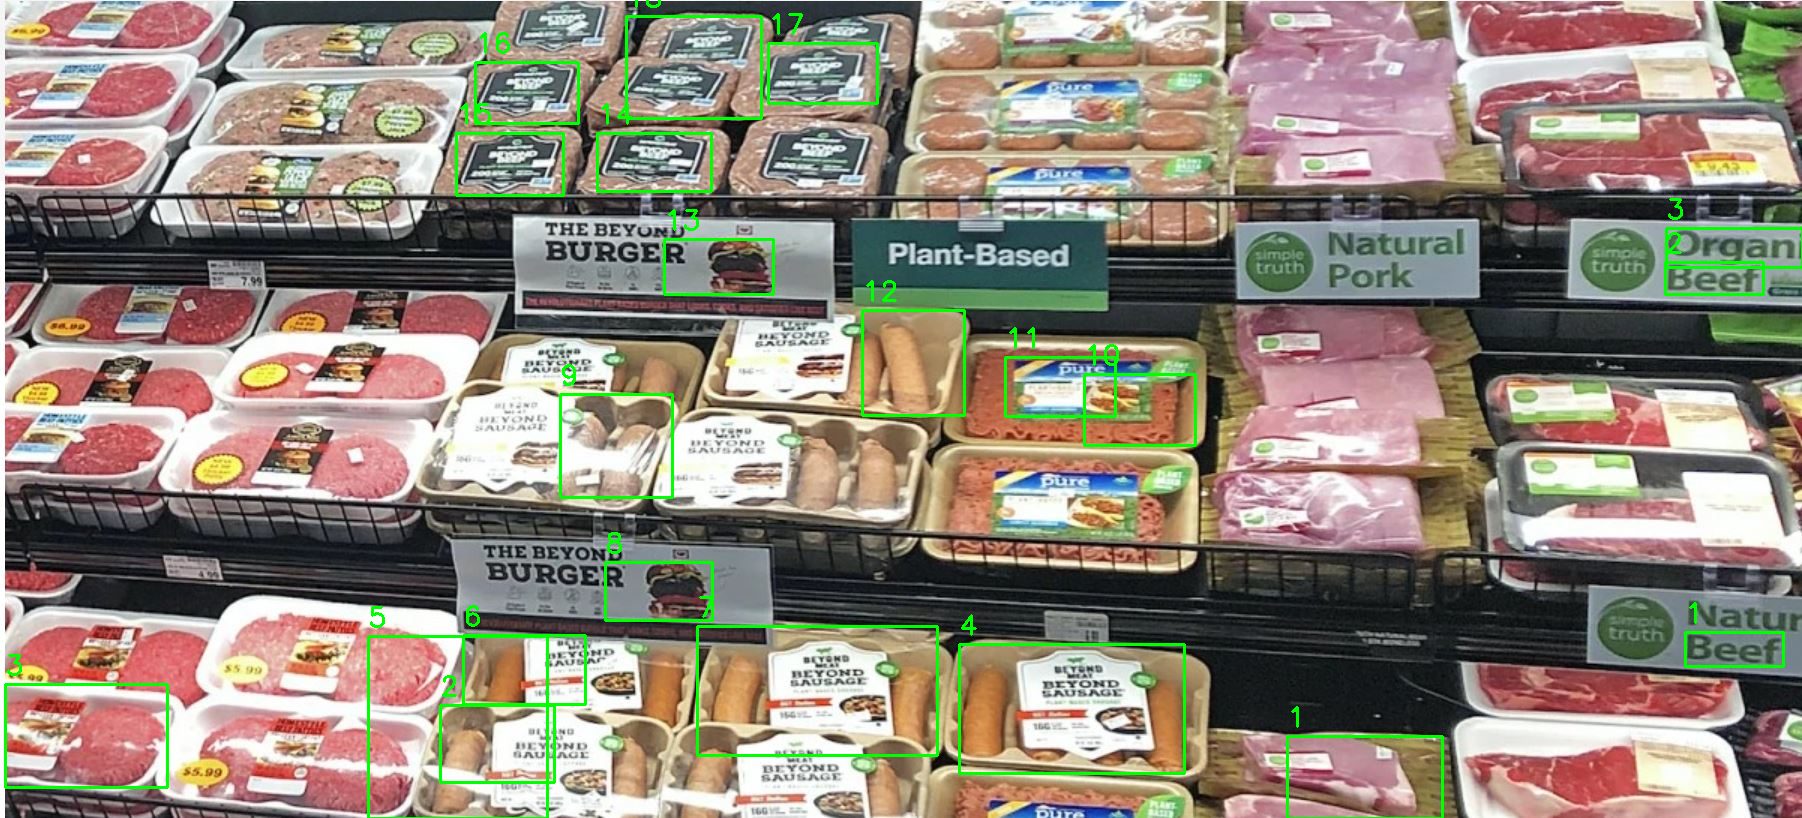

Detected 3 meat packages:

Package 1:
Position: (1685, 632)
Dimensions (pixels): 98 x 34 pixels
Dimensions (inches): 6.00 x 2.08 inches
Beef
Dominant Colors: RGB117 (0.58%), RGB56 (0.27%), RGB87 (0.16%)
Estimated Price: N/A

Package 2:
Position: (1665, 262)
Dimensions (pixels): 98 x 32 pixels
Dimensions (inches): 6.00 x 1.96 inches
Beef
Dominant Colors: RGB153 (0.51%), RGB78 (0.31%), RGB115 (0.18%)
Estimated Price: N/A

Package 3:
Position: (1666, 228)
Dimensions (pixels): 136 x 39 pixels
Dimensions (inches): 8.33 x 2.39 inches
Organi
Dominant Colors: RGB116 (0.18%), RGB154 (0.56%), RGB74 (0.26%)
Estimated Price: N/A


In [41]:
# Run the analysis
results = analyze_meat_shelf()
print(f"Detected {len(results)} meat packages:")
for result in results:
    print(f"\nPackage {result['package_id']}:")
    print(f"Position: {result['position']}")
    print(f"Dimensions (pixels): {result['dimensions_pixels']}")
    print(f"Dimensions (inches): {result['dimensions_inches']}")
    print(f"Detected Text: {result['text'][:50]}..." if len(result['text']) > 50 else result['text'])
    print(f"Dominant Colors: {', '.join([f'RGB{color[0]} ({percentage:.2f}%)' for color, percentage in result['dominant_colors']])}")
    print(f"Estimated Price: {result['estimated_price']}")